In [1]:
import scanpy as sc
import pandas as pd
import sys
from scipy.stats import pearsonr
#from generate_gene_block import plot_gene_block
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from generate_gene_block import plot_gene_block
from matplotlib.lines import Line2D
from scipy import stats

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 200)

mpl.rcParams['font.family'] = 'NimbusSanL'
plt.rcParams['pdf.fonttype'] = 42

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)
cluster_nde75_ntotal50 = pd.read_csv('../../metadata/clustering_results.csv', index_col=0)

In [3]:
# Define core TCR signaling genes (they also cluster in cluster 22)
core_tcr = ['CD3D', 'CD3E', 'CD3G', 'CD247', 'ZAP70', 'LAT', 'VAV1', 'LCP2', 'PLCG1']
core_tcr_geneid = cluster_nde75_ntotal50[cluster_nde75_ntotal50['target_contrast_gene_name_corrected'].isin(core_tcr)]['target_contrast_corrected'].unique().tolist()
core_tcr_geneid_stim8hr = [item+'_Stim8hr' for item in core_tcr_geneid]
core_tcr_geneid_stim48hr = [item+'_Stim48hr' for item in core_tcr_geneid]

## Make the gene blocks

In [ ]:
tact_cl = [21, 22, 99]
for cl in tact_cl:
    geneid_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected'].unique().tolist()
    genename_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_gene_name_corrected'].unique().tolist()
    for i, geneid in enumerate(geneid_list):
        if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
            sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                            corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
            plot_gene_block(genename_list[i], sample_measurements, colormap='BrBG_r', vmin=-0.7, vmax=0.7, incluster=True,
                            output_filename='./results/for_TCR_schematics/'+genename_list[i]+'_cluster'+str(cl)+'.pdf')

## Make correlation matrix among activation regulators

In [6]:
T_activation_cluster_obs = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan'].isin([21, 22, 99])].copy()
# Get all the regulators that have measurements in both Stim8hr and Stim48hr (exclude dropouts)
regulator_id_all = T_activation_cluster_obs.target_contrast_corrected.unique().tolist() 
regulator_id_all = [reg for reg in regulator_id_all if reg+'_Stim8hr' in corr_df_all.index]
regulator_id_all = [reg for reg in regulator_id_all if reg+'_Stim48hr' in corr_df_all.index]
# Get list of early regulators
early_regulator_id = [reg_id for reg_id in regulator_id_all if (reg_id+'_Stim8hr' in T_activation_cluster_obs.index)&(reg_id+'_Stim48hr' not in T_activation_cluster_obs.index)]
# Get list of late regulators
late_regulator_id = [reg_id for reg_id in regulator_id_all if (reg_id+'_Stim8hr' not in T_activation_cluster_obs.index)&(reg_id+'_Stim48hr' in T_activation_cluster_obs.index)]
# Get list of general regulators
general_regulator_id = [reg_id for reg_id in regulator_id_all if (reg_id+'_Stim8hr' in T_activation_cluster_obs.index)&(reg_id+'_Stim48hr' in T_activation_cluster_obs.index)]

In [8]:
### Save list of early, late, general regulators
Tact_all = early_regulator_id + late_regulator_id + general_regulator_id
Tact_label = ['early_regulator']*len(early_regulator_id) + ['late_regulator']*len(late_regulator_id) + ['general_regulator']*len(general_regulator_id)
Tact_df = pd.DataFrame({'regulator_gene_id': Tact_all, 'regulator_label': Tact_label})
Tact_df.to_csv('./results/T_activation_regulators.csv')

In [9]:
method = 'ward'
metric = 'euclidean'
# Get the order of early regulators by co-clustermap early regulators with general regulators
early_regulator_id_stim8 = [item+'_Stim8hr' for item in early_regulator_id]
general_regulator_id_stim8 = [item+'_Stim8hr' for item in general_regulator_id]
early_general_regulator_id_stim8 = early_regulator_id_stim8 + general_regulator_id_stim8

# Get reordered genes based on clustermap
#clustermap = sns.clustermap(corr_df_all.loc[early_regulator_id_stim8, early_general_regulator_id_stim8],
clustermap = sns.clustermap(corr_df_all.loc[early_regulator_id_stim8, early_regulator_id_stim8],
                            method=method, 
                            metric=metric)
row_indices = clustermap.dendrogram_row.reordered_ind
plt.close(clustermap.fig)
early_regulator_id_reordered = np.array(early_regulator_id)[row_indices][::-1]

# Get the order of late regulators by co-clustermap late regulators with general regulators
late_regulator_id_stim48 = [item+'_Stim48hr' for item in late_regulator_id]
general_regulator_id_stim48 = [item+'_Stim48hr' for item in general_regulator_id]
general_late_regulator_id_stim48 = general_regulator_id_stim48 + late_regulator_id_stim48

# Get reordered genes based on clustermap
#clustermap = sns.clustermap(corr_df_all.loc[late_regulator_id_stim48, general_late_regulator_id_stim48],
clustermap = sns.clustermap(corr_df_all.loc[late_regulator_id_stim48, late_regulator_id_stim48],
                            method=method, 
                            metric=metric)
row_indices = clustermap.dendrogram_row.reordered_ind
plt.close(clustermap.fig)
late_regulator_id_reordered = np.array(late_regulator_id)[row_indices]

# Reorder the general regulators
#clustermap = sns.clustermap(corr_df_all.loc[general_regulator_id_stim8, early_general_regulator_id_stim8],
clustermap = sns.clustermap(corr_df_all.loc[general_regulator_id_stim8, general_regulator_id_stim8],
                            method=method, 
                            metric=metric)
row_indices = clustermap.dendrogram_row.reordered_ind
plt.close(clustermap.fig)
general_regulator_id_reordered_v1 = np.array(general_regulator_id)[row_indices][::-1]

#clustermap = sns.clustermap(corr_df_all.loc[general_regulator_id_stim48, general_late_regulator_id_stim48],
clustermap = sns.clustermap(corr_df_all.loc[general_regulator_id_stim48, general_regulator_id_stim48],
                            method=method, 
                            metric=metric)
row_indices = clustermap.dendrogram_row.reordered_ind
plt.close(clustermap.fig)
general_regulator_id_reordered_v2 = np.array(general_regulator_id)[row_indices]

# Small script to reorder the general regulators such that regulators with high correlated effects are place at the center
general_regulator_id_to_be_reordered = np.array(list(general_regulator_id_reordered_v1) + list(general_regulator_id_reordered_v2))

N = len(general_regulator_id_to_be_reordered)
center_index = (N - 1) / 2.0 
gene_distance_map = {}
for i, gene_id in enumerate(general_regulator_id_to_be_reordered):
    distance = abs(i - center_index)
    if gene_id not in gene_distance_map or distance < gene_distance_map[gene_id]:
        gene_distance_map[gene_id] = distance
unique_genes_sorted_by_closeness = sorted(
    gene_distance_map.keys(), 
    key=lambda gene: gene_distance_map[gene]
)

general_regulator_id_reordered = []

for i, gene in enumerate(unique_genes_sorted_by_closeness):
    if i % 2 == 0:
        general_regulator_id_reordered.insert(0, gene)
    else:
        general_regulator_id_reordered.append(gene)

regulator_id_reordered = list(early_regulator_id_reordered) + general_regulator_id_reordered + list(late_regulator_id_reordered)

In [11]:
thres = 0.4

<Axes: >

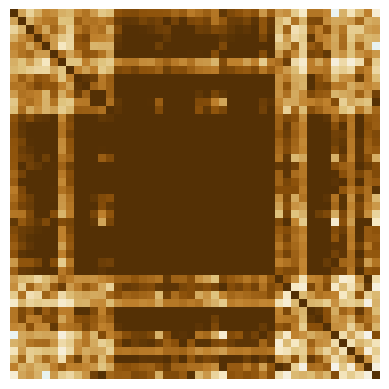

In [12]:
general_regulator_id_reordered_stim8 = [reg+'_Stim8hr' for reg in general_regulator_id_reordered]
sns.heatmap(corr_df_all.loc[general_regulator_id_reordered_stim8, general_regulator_id_reordered_stim8],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True)

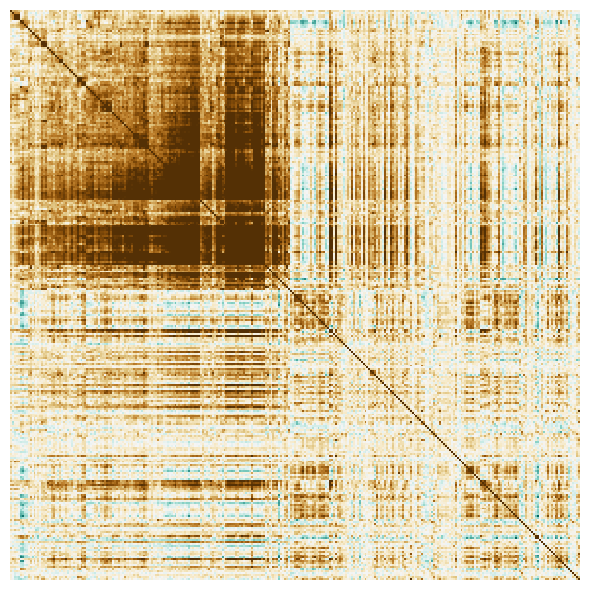

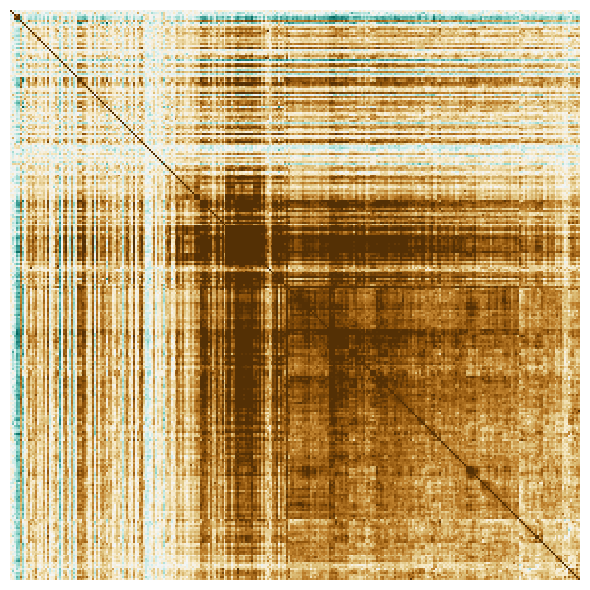

In [13]:
regulator_id_reordered_stim8 = [reg+'_Stim8hr' for reg in regulator_id_reordered]
regulator_id_reordered_stim48 = [reg+'_Stim48hr' for reg in regulator_id_reordered]

# Create figure with space for color bars
fig, ax = plt.subplots(figsize=(6, 6))#, constrained_layout=True)

# Create heatmap
sns.heatmap(corr_df_all.loc[regulator_id_reordered_stim8, regulator_id_reordered_stim8],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True, ax=ax)

plt.tight_layout()
plt.savefig('./results/Tact_reg_stim8hr.png', dpi=600, bbox_inches='tight', pad_inches=0)

# Create figure with space for color bars
fig, ax = plt.subplots(figsize=(6, 6))#, constrained_layout=True)

# Create heatmap
sns.heatmap(corr_df_all.loc[regulator_id_reordered_stim48, regulator_id_reordered_stim48],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True, ax=ax)

plt.tight_layout()
plt.savefig('./results/Tact_reg_stim48hr.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Check GO enrichment of genes enriched in early regulators or late regulators

In [14]:
Tact_df = pd.read_csv('./results/T_activation_regulators.csv', index_col=0)

In [15]:
# Getting downstream genes from early regulators in Stim8hr and Stim48hr
df_early = pd.DataFrame()
regulator_label = 'early_regulator'

# Getting condition-specific downstream genes of cluster regulators
cond = 'Stim8hr'
geneid_list = Tact_df[Tact_df['regulator_label'].isin([regulator_label, 'general_regulator'])]['regulator_gene_id']
obs_names = [geneid+'_'+cond for geneid in geneid_list]
adata_subset = adata_de[adata_de.obs_names.isin(obs_names)].to_memory().copy()
# First only consider DE gene for at least one cluster member regulator
adata_subset = adata_subset[:,(adata_subset.layers['adj_p_value']<0.1).sum(0)>=1].copy()
downstream_gene_list = adata_subset.var['gene_name'].tolist()
downstream_gene_ids_list = adata_subset.var['gene_ids'].tolist()
# Calculate simple number of upstream regulators for each gene
num_of_upstream = (adata_subset.layers['adj_p_value']<0.1).sum(0)
sign_coherence = ((adata_subset.layers['adj_p_value']<0.1) * (np.sign(adata_subset.layers['zscore']))).sum(0) / num_of_upstream
# For each member regulator, calculate the rank of downstream genes based on zscore, then add the rank together and rank based on sum rank
zscore_rank_neg = stats.rankdata(stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
zscore_rank_pos = stats.rankdata(-stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
# Summarize into dataFrame
df = pd.DataFrame({'regulator_label': regulator_label,
                   'downstream_gene': downstream_gene_list,
                   'downstream_gene_ids': downstream_gene_ids_list,
                   'num_of_upstream': num_of_upstream,
                   'sign_coherence': sign_coherence,
                   'zscore_rank_negative_regulation': zscore_rank_neg,
                   'zscore_rank_positive_regulation': zscore_rank_pos,
                   'condition': cond})
df_early = pd.concat([df_early, df])
df_early = df_early.set_index('downstream_gene')
    
# Getting downstream genes from late regulators in Stim8hr and Stim48hr
df_late = pd.DataFrame()
regulator_label = 'late_regulator'

# Getting condition-specific downstream genes of cluster regulators
cond = 'Stim48hr'
geneid_list = Tact_df[Tact_df['regulator_label'].isin([regulator_label, 'general_regulator'])]['regulator_gene_id']
obs_names = [geneid+'_'+cond for geneid in geneid_list]
adata_subset = adata_de[adata_de.obs_names.isin(obs_names)].to_memory().copy()
# First only consider DE gene for at least one cluster member regulator
adata_subset = adata_subset[:,(adata_subset.layers['adj_p_value']<0.1).sum(0)>=1].copy()
downstream_gene_list = adata_subset.var['gene_name'].tolist()
downstream_gene_ids_list = adata_subset.var['gene_ids'].tolist()
# Calculate simple number of upstream regulators for each gene
num_of_upstream = (adata_subset.layers['adj_p_value']<0.1).sum(0)
sign_coherence = ((adata_subset.layers['adj_p_value']<0.1) * (np.sign(adata_subset.layers['zscore']))).sum(0) / num_of_upstream
# For each member regulator, calculate the rank of downstream genes based on zscore, then add the rank together and rank based on sum rank
zscore_rank_neg = stats.rankdata(stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
zscore_rank_pos = stats.rankdata(-stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
# Summarize into dataFrame
df = pd.DataFrame({'regulator_label': regulator_label,
                   'downstream_gene': downstream_gene_list,
                   'downstream_gene_ids': downstream_gene_ids_list,
                   'num_of_upstream': num_of_upstream,
                   'sign_coherence': sign_coherence,
                   'zscore_rank_negative_regulation': zscore_rank_neg,
                   'zscore_rank_positive_regulation': zscore_rank_pos,
                   'condition': cond})
df_late = pd.concat([df_late, df])
df_late = df_late.set_index('downstream_gene')

In [16]:
common_gene = np.intersect1d(df_early.index, df_late.index)
rank1 = np.array(df_early.loc[common_gene, 'zscore_rank_negative_regulation'])
rank2 = np.array(df_late.loc[common_gene, 'zscore_rank_negative_regulation'])
rank1_norm = 1 - (rank1 - np.min(rank1)) / np.max(rank1)
rank2_norm = 1 - (rank2 - np.min(rank2)) / np.max(rank2)

df_rank = pd.DataFrame({'Gene': common_gene, 'rank_norm_stim8hr': rank1_norm, 'rank_norm_stim48hr': rank2_norm})
df_rank['rank_diff'] = df_rank['rank_norm_stim8hr'] - df_rank['rank_norm_stim48hr']
df_rank['log_rank_diff'] = np.log(df_rank['rank_norm_stim8hr']) - np.log(df_rank['rank_norm_stim48hr'])

In [17]:
import gseapy as gp

go_bp_sets = gp.get_library(name='GO_Biological_Process_2025', organism='Human')

In [18]:
# Check top top_thres genes that are positively regulated by early or late cluster with ranking difference of at least rank_diff
top_thres = 0.7
rank_diff = 0.5
padj_thres = 0.05

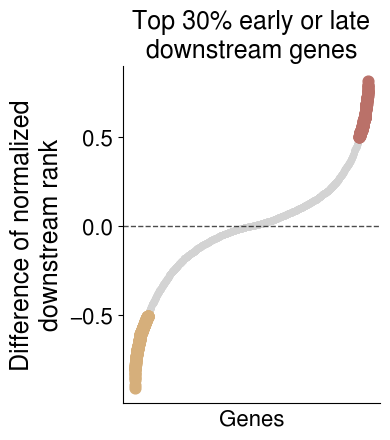

In [19]:
# Sort the DataFrame by rank_diff
# Reset index so we can use the new index as the x-axis (Rank Position)
mask = (df_rank['rank_norm_stim8hr']>top_thres) | (df_rank['rank_norm_stim48hr']>top_thres) # Choose only top positively regulated genes
df_sorted = df_rank[mask].sort_values('rank_diff').reset_index(drop=True)

# Identify which rows match our canonical list
# We create a boolean mask or filter specifically for the highlights
early_df = df_sorted[df_sorted['rank_diff']>rank_diff]
late_df = df_sorted[df_sorted['rank_diff']<-rank_diff]

# Setup the Plot
fig, ax = plt.subplots(figsize=(4, 4.5))
sns.set_style("white")

# Plot the background (all genes)
# We use the index for X (Rank) and rank_diff for Y
ax.scatter(df_sorted.index, df_sorted['rank_diff'], 
            c='lightgrey', s=15, alpha=0.5, rasterized=True)

# Plot the early downstream genes
ax.scatter(early_df.index, early_df['rank_diff'], 
            c='#ba7169', s=60, rasterized=True)

# Plot the late downstream genes
ax.scatter(late_df.index, late_df['rank_diff'], 
            c='#d6af7b', s=60, rasterized=True)

# Formatting
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xticks([])
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Difference of normalized\ndownstream rank', fontsize=18)
ax.set_title(f'Top {1-top_thres:.0%} early or late\ndownstream genes', fontsize=18)

sns.despine()

plt.tight_layout()
plt.savefig('./results/early_vs_late_normalized_rank_diff.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

### Check downstream GO enrichment for downstream genes in either direction

In [20]:
def wrap_long_label_at_middle_space(label, max_length=40):
    """
    Wraps a long label by inserting a newline (\n) at the space closest to the middle.
    """
    if len(label) > max_length:
        # 1. Split the label into words
        words = label.split(' ')
        num_words = len(words)

        if num_words > 1:
            # 2. Find the index for the split point (e.g., for 6 words, split after 3rd word)
            # The split index will be len(words) // 2
            split_index = num_words // 2 + 1

            # 3. Join the first half with spaces, then add a newline, and join the second half with spaces
            line1 = ' '.join(words[:split_index])
            line2 = ' '.join(words[split_index:])
            return f'{line1}\n{line2}'

    return label

def remove_duplicated_go(df, overlap_thres=0.3):
    # Convert string of genes into sets
    df['gene_set_temp'] = df['Genes'].str.split(';').apply(set)
    # Sort by P-value to prioritize the most significant terms
    df = df.sort_values('P-value')
    keep_indices = []
    seen_gene_sets = []
    for index, row in df.iterrows():
        current_genes = row['gene_set_temp']
        is_duplicate = False
        # Compare current row against rows we have already decided to keep
        for seen_genes in seen_gene_sets:
            intersection = len(current_genes.intersection(seen_genes))
            # Check if overlap is > overlap_thres of the current set OR > overlap_thres of the seen set
            if (intersection > overlap_thres * len(current_genes)) or \
               (intersection > overlap_thres * len(seen_genes)):
                is_duplicate = True
                break
        if not is_duplicate:
            keep_indices.append(index)
            seen_gene_sets.append(current_genes)
    
    # Create the final consolidated dataframe
    df_clean = df.loc[keep_indices].drop(columns=['gene_set_temp'])
    df_clean = df_clean.reset_index(drop=True)
    return df_clean

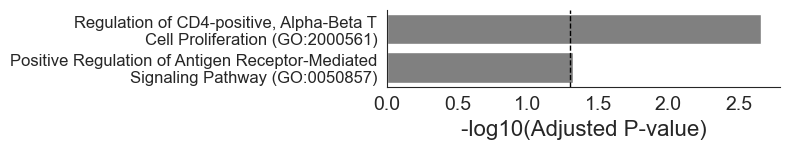

In [21]:
bg = df_rank.Gene.tolist()
enr = gp.enrichr(gene_list=df_rank[(df_rank['rank_diff']>rank_diff)&(df_rank['rank_norm_stim8hr']>top_thres)].Gene.tolist(), 
                gene_sets=[go_bp_sets],# go_cc_sets],
                organism='human',
                outdir=None,
                background=bg
                )
df = enr.results.copy()
df = df[df['Adjusted P-value'] < padj_thres]
df['Neglog_p'] = -np.log10(df['Adjusted P-value'])

# Remove duplicated terms
df = remove_duplicated_go(df)

df['Wrapped_Term'] = df['Term'].apply(wrap_long_label_at_middle_space)

df = df.sort_values('Neglog_p', ascending=False)
plt.figure(figsize=(8, 0.5*len(df)+0.6))
sns.barplot(data=df, x='Neglog_p', y='Wrapped_Term', color='gray')
threshold = -np.log10(padj_thres)
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=1)
plt.xlabel('-log10(Adjusted P-value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('') # Remove y-axis label
sns.despine()
plt.tight_layout()
plt.savefig('./results/early_specific_downstream_go_enrichment.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

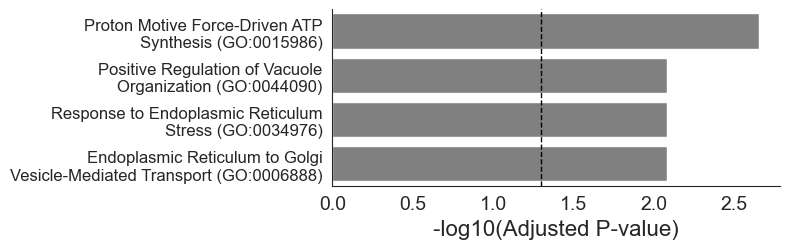

In [22]:
bg = df_rank.Gene.tolist()
enr = gp.enrichr(gene_list=df_rank[(df_rank['rank_diff']<-rank_diff)&(df_rank['rank_norm_stim48hr']>top_thres)].Gene.tolist(), 
                gene_sets=[go_bp_sets],# go_cc_sets],
                organism='human',
                outdir=None,
                background=bg
                )
df = enr.results.copy()
df = df[df['Adjusted P-value'] < padj_thres]
df['Neglog_p'] = -np.log10(df['Adjusted P-value'])

# Remove duplicated terms
df = remove_duplicated_go(df)

df['Wrapped_Term'] = df['Term'].apply(wrap_long_label_at_middle_space)

df = df.sort_values('Neglog_p', ascending=False)
plt.figure(figsize=(8, 0.5*len(df)+0.6))
sns.barplot(data=df, x='Neglog_p', y='Wrapped_Term', color='gray')
threshold = -np.log10(padj_thres)
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=1)
plt.xlabel('-log10(Adjusted P-value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('') # Remove y-axis label
sns.despine()
plt.tight_layout()
plt.savefig('./results/late_specific_downstream_go_enrichment.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

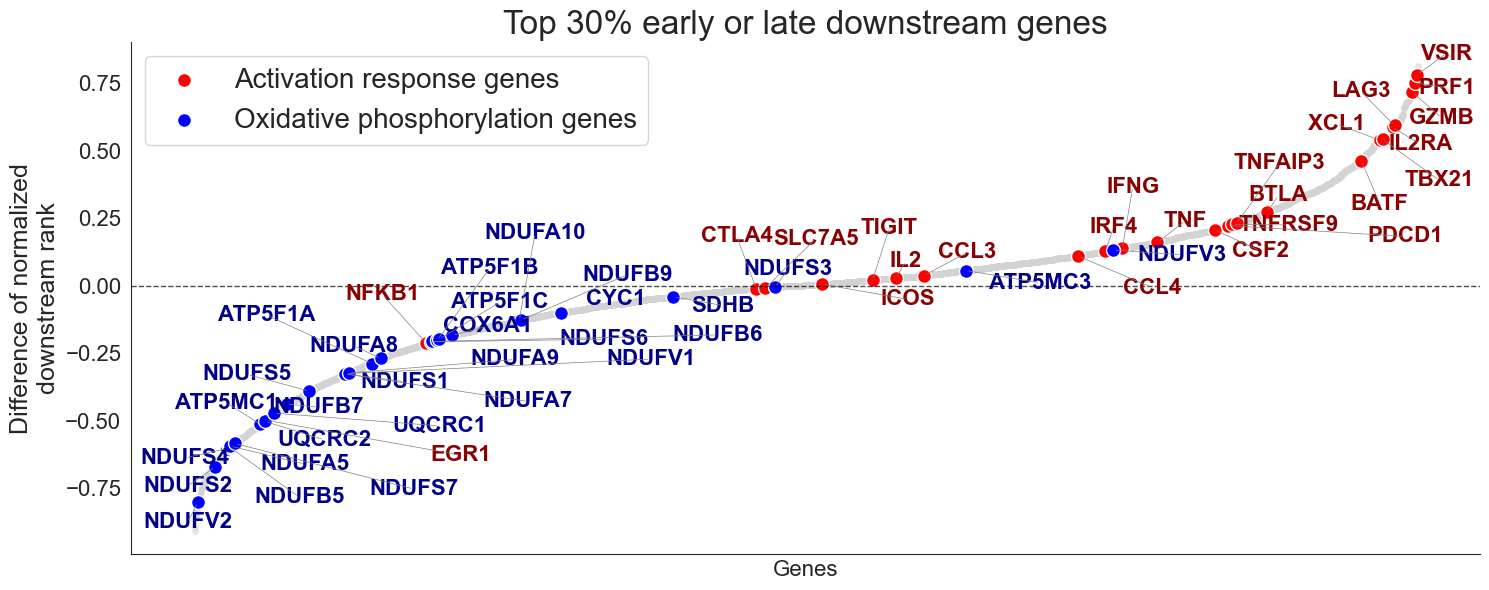

In [23]:
canonical_t_cell_genes = [
    # Immediate response genes
    'FOS', 'JUN', 'JUNB', 'EGR1', 'NR4A1', 'NFKB1',
    
    # Cytokines/Effectors
    'IL2', 'TNF', 'IFNG', 'CD69', 'CSF2', 'CCL3', 'CCL4', 'XCL1', 'GZMB', 'PRF1', 'ICAM1',
    
    # Co-stimulatory
    'IL2RA', 'CD40LG', 'ICOS', 'TNFRSF4', 'TNFRSF9', 'TNFRSF18',
    
    # Checkpoints / Feedback
    'PDCD1', 'LAG3', 'HAVCR2', 'CTLA4', 'TIGIT', 'BTLA', 'VSIR', 'TNFAIP3',
    
    # Transcription/Metabolic Regulators
    'IRF4', 'BATF', 'TBX21', 'PRDM1', 'SLC2A1', 'SLC7A5', 'MKI67'
]

canonical_oxphos_genes = [
    # Complex I: NADH:Ubiquinone Oxidoreductase
    "MT-ND1", "MT-ND2", "MT-ND3", "MT-ND4", "MT-ND4L", "MT-ND5", "MT-ND6",
    "NDUFA1", "NDUFA2", "NDUFA3", "NDUFA4", "NDUFA5", "NDUFA6", "NDUFA7", "NDUFA8", "NDUFA9", "NDUFA10", "NDUFA11", "NDUFA12", "NDUFA13",
    "NDUFB1", "NDUFB2", "NDUFB3", "NDUFB4", "NDUFB5", "NDUFB6", "NDUFB7", "NDUFB8", "NDUFB9", "NDUFB10", "NDUFB11",
    "NDUFS1", "NDUFS2", "NDUFS3", "NDUFS4", "NDUFS5", "NDUFS6", "NDUFS7", "NDUFS8",
    "NDUFV1", "NDUFV2", "NDUFV3",

    # Complex II: Succinate Dehydrogenase (SDH)
    "SDHA", "SDHB", "SDHC", "SDHD",

    # Complex III: Cytochrome bc1 Complex
    "MT-CYB",
    "UQCRC1", "UQCRC2",
    "CYC1",

    # Complex IV: Cytochrome c Oxidase (COX)
    "MT-CO1", "MT-CO2", "MT-CO3",
    "COX4I1",
    "COX5A", "COX5B",
    "COX6A1", "COX6B1", "COX6C",
    "COX7A1", "COX7B", "COX7C",
    "COX8A",

    # Complex V: ATP Synthase
    "MT-ATP6", "MT-ATP8",
    "ATP5F1A", "ATP5F1B", "ATP5F1C",
    "ATP5PO",
    "ATP5MC1", "ATP5MC2", "ATP5MC3"
]

# 2. Sort the DataFrame by rank_diff
# Reset index so we can use the new index as the x-axis (Rank Position)
mask = (df_rank['rank_norm_stim8hr']>top_thres) | (df_rank['rank_norm_stim48hr']>top_thres)
df_sorted = df_rank[mask].sort_values('rank_diff').reset_index(drop=True)

# 3. Identify which rows match our canonical list
# We create a boolean mask or filter specifically for the highlights
t_act_df = df_sorted[df_sorted['Gene'].isin(canonical_t_cell_genes)]
oxphos_df = df_sorted[df_sorted['Gene'].isin(canonical_oxphos_genes)]

# 4. Setup the Plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.set_style("white")

# Plot the background (all genes)
# We use the index for X (Rank) and rank_diff for Y
ax.scatter(df_sorted.index, df_sorted['rank_diff'], 
            c='lightgrey', s=15, alpha=0.5, label=f'All top {1-top_thres:.0%} positively regulated genes in either early or late clusters', rasterized=True)

# Plot the T cell activation response genes
ax.scatter(t_act_df.index, t_act_df['rank_diff'], 
            c='red', s=100, edgecolors='white', linewidth=1, label='Activation response genes', rasterized=True)

# Plot the oxidative phosphorylation genes
ax.scatter(oxphos_df.index, oxphos_df['rank_diff'], 
            c='blue', s=100, edgecolors='white', linewidth=1, label='Oxidative phosphorylation genes', rasterized=True)

# 5. Add Labels with text adjustment
texts = []
for idx, row in t_act_df.iterrows():
    # We append text objects to a list to adjust them later
    texts.append(ax.text(idx, row['rank_diff'], row['Gene'], 
                          fontsize=16, fontweight='bold', color='darkred'))

for idx, row in oxphos_df.iterrows():
    texts.append(ax.text(idx, row['rank_diff'], row['Gene'], 
                          fontsize=16, fontweight='bold', color='darkblue'))

adjust_text(texts, #x=df_sorted.index.tolist(), y=df_sorted['rank_diff'].tolist(),
            arrowprops=dict(arrowstyle='-', color='grey', lw=0.5),
            expand_points=(1.5, 1.5))

# 6. Formatting
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xticks([])
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim([-200,len(df_sorted)*1.05])
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Difference of normalized\ndownstream rank', fontsize=18)
ax.set_title(f'Top {1-top_thres:.0%} early or late downstream genes', fontsize=24)

handles, labels = ax.get_legend_handles_labels()
handles_to_show = handles[1:]
labels_to_show = labels[1:]
ax.legend(handles_to_show, labels_to_show, fontsize=20, loc='upper left')
sns.despine()

plt.tight_layout()
plt.savefig('./results/early_vs_late_normalized_rank_diff_with_annotation.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()